## DATA 558: Homework 6

Geoffrey Li

May 24, 2019

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exercise 1

### 1.1: Load and Standardize Data

In [2]:
# Load the data
hitters = pd.read_csv(
    'https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv',
    sep=',', header=0)
hitters.dropna(inplace=True)
hitters.reset_index(drop=True, inplace=True)

In [3]:
# Create our X matrix with the predictors and y vector with the response
X = hitters.drop('Salary', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = hitters.Salary

In [4]:
# Divide the data into training and test sets. By default, 25% goes into the test set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# Standardize the data
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """
/anaconda3/envs/data558/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


In [6]:
# We need to convert the y's to arrays before standardizing them
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Standardize y's
scaler = preprocessing.StandardScaler().fit(y_train[:, np.newaxis])
y_train = scaler.transform(y_train[:, np.newaxis])
y_test = scaler.transform(y_test[:, np.newaxis])

### 1.2: Gradient Functions

Write a function computeobj that computes and returns F(β) for any β.

In [7]:
# Computes Objective Value given x, y, beta, and lambda
def computeobj(x, y, b, lamb):
    return 1/len(x)*np.sum((y - x@b)**2)+lamb*np.sum(np.abs(b))

### 1.3: Run sklearn.LassoCV for optimal $\lambda$ and results to compare against

Run cross-validation on the training set of the Hitters dataset using scikit-learn to find the optimal value of λ.

In [8]:
from sklearn.linear_model import LassoCV

lassocv = LassoCV(fit_intercept=False, tol=10e-8, max_iter=1000, cv=5)
lassocv.fit(X_train, y_train.squeeze())
opt_lamb = lassocv.alpha_*2 #different objective function from ours

/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did no

/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did no

Note that lambda = 2*alpha since sklearn's objective function is multiplied by a factor of 1/2

In [9]:
print('Optimal lambda =', opt_lamb)

Optimal lambda = 0.06890599408677459


In [10]:
beta_sklearn_T = lassocv.coef_[:, np.newaxis]
beta_sklearn_T.squeeze()

array([-0.        ,  0.19443281,  0.04208511,  0.        ,  0.01242786,
        0.11473224, -0.        ,  0.        ,  0.33605642,  0.        ,
        0.06475386,  0.        , -0.        ,  0.09943416, -0.        ,
       -0.02653755,  0.        , -0.09841983,  0.        ])

In [29]:
obj_sklearn = computeobj(X_train, y_train, beta_sklearn_T, opt_lamb)
obj_sklearn

0.6384025391163657

### 1.4: Cyclic Coordinate Descent

Write a function cycliccoorddescent that implements the cyclic coordinate descent al- gorithm. The cyclic coordinate descent algorithm proceeds sequentially. At each iter- ation, the algorithm increments the index jt of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate βjt cor- responding to that index. After updating the coordinate βjt, the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.

In [12]:
def calc_beta_j(x, y, b, lamb, j):
    c_j = 2/len(x)*np.sum(np.dot(x[:, j], y - x[:, np.arange(x.shape[1])!=j] @ b[np.arange(b.shape[0])!=j, :]))
    a_j = 2/len(x)*np.sum(x[:, j]**2)
    
    if c_j >= -lamb and c_j <= lamb:
        return 0
    elif c_j < -lamb:
        return (c_j+lamb)/a_j
    elif c_j > lamb:
        return (c_j-lamb)/a_j

In [13]:
def cycliccoorddescent(x, y, beta, lamb, max_iter=1000):
    beta_list = [beta]
    
#     for i in range(max_iter):
#         for j in range(x.shape[1]):
#             beta = beta.copy()
#             beta[j] = calc_beta_j(x, y, beta, lamb, j)
#         beta_list.append(beta)
    
    i = 1
    j = 0
    while i < max_iter:
        beta = beta.copy()
        beta[j] = calc_beta_j(x, y, beta, lamb, j)
        beta_list.append(beta)
        
        i += 1
        if j == x.shape[1]-1:
            j = 0
        else:
            j += 1
    
    return beta_list

In [14]:
beta_init = np.zeros(X_train.shape[1])[:, np.newaxis]

beta_cyc = cycliccoorddescent(X_train, y_train, beta_init, opt_lamb, max_iter=1000)
beta_cyc_T = beta_cyc[len(beta_cyc)-1]

In [15]:
beta_cyc_T.squeeze()

array([ 0.        ,  0.19468224,  0.04516322,  0.        ,  0.00927173,
        0.11667428,  0.        ,  0.        ,  0.35584497,  0.        ,
        0.04473501,  0.        ,  0.        ,  0.09879323,  0.        ,
       -0.02685906,  0.        , -0.09913728,  0.        ])

In [28]:
obj_cyc = computeobj(X_train, y_train, beta_cyc_T, opt_lamb)
obj_cyc

0.6384125903922866

In [30]:
# Error between sklearn and cyclic coordinate descent
# Results are very close
(obj_cyc - obj_sklearn)/obj_sklearn

1.5744417205514975e-05

### 1.5: Random Coordinate Descent

Write a function pickcoord that samples uniformly from the set {1, . . . , d} .

In [17]:
def pickcoord(d):
    return np.random.randint(0, d)

Write a function randcoorddescent that implements the randomized coordinate descent algorithm. The randomized coordinate descent algorithm proceeds as follows. At each iteration, the algorithm samples the index jt of the coordinate to minimize over. Then the algorithm performs partial minimization with respect to the coordinate βjt corresponding to that index. After updating the coordinate βjt , the algorithm proceeds to the next iteration. The function takes as input the initial point and the maximum number of iterations. The stopping criterion is the maximum number of iterations.

In [18]:
def randcoorddescent(x, y, beta, lamb, max_iter=1000):
    beta_list = list()
    for i in range(max_iter):
        beta_list.append(beta)
        beta = beta.copy()
        j = pickcoord(x.shape[1])
        beta[j] = calc_beta_j(x, y, beta, lamb, j)
    
    return beta_list

In [19]:
beta_init = np.zeros(X_train.shape[1])[:, np.newaxis]

beta_rand = randcoorddescent(X_train, y_train, beta_init, opt_lamb, max_iter=1000)
beta_rand_T = beta_rand[len(beta_rand)-1]

In [20]:
beta_rand_T.squeeze()

array([ 0.        ,  0.19429653,  0.03551468,  0.        ,  0.01878964,
        0.11011843,  0.        ,  0.        ,  0.29176425,  0.        ,
        0.11075742,  0.        ,  0.        ,  0.10088944,  0.        ,
       -0.02578302,  0.        , -0.09685941,  0.        ])

In [31]:
obj_rand = computeobj(X_train, y_train, beta_rand_T, opt_lamb)
obj_rand

0.6384541340407944

In [32]:
# Error between sklearn and random coordinate descent
# Results are very close
(obj_rand - obj_sklearn)/obj_sklearn

8.081879577132976e-05

### 1.6: Objective Value vs. Iteration

Set the maximum number of iterations to 1000. In the remainder, the iteration counter iter refers here to t/d, that is the effective number of passes over all coordinates. Run cycliccoorddescent and randcoorddescent on the training set of the Hitters dataset for that value of λ found by cross-validation. Plot the curves of the objective values F(βt) for both algorithms versus the iteration counter iter (use different colors). What do you observe?


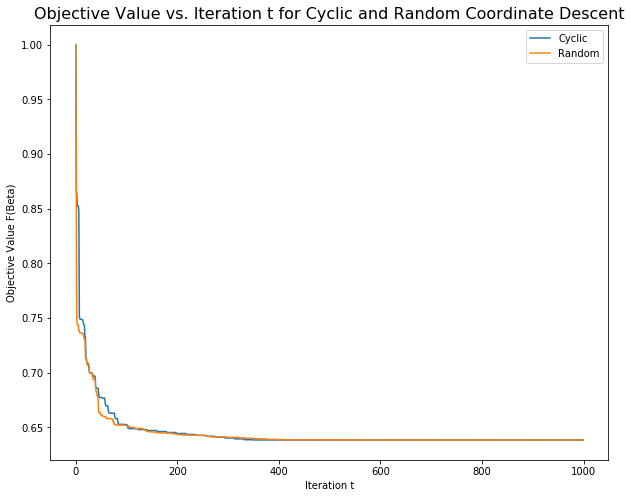

In [22]:
plt.figure(figsize=(10,8))
plt.plot(range(len(beta_cyc)), list(map(lambda b: computeobj(X_train, y_train, b, opt_lamb), beta_cyc)))
plt.plot(range(len(beta_rand)), list(map(lambda b: computeobj(X_train, y_train, b, opt_lamb), beta_rand)))
plt.legend(['Cyclic', 'Random'], loc='upper right')
plt.title('Objective Value vs. Iteration t for Cyclic and Random Coordinate Descent', fontsize=16)
plt.xlabel('Iteration t')
plt.ylabel('Objective Value F(Beta)');

We see that both coordinate descent algorithms converge at roughly the same rate. Random appears to have slightly faster convergence. Both descent algorithms converge at roughly 200 iterations, which on average is around 10 iterations through all the features (since there are d = 19 features).

### 1.7: Fraction of Correct Coefficients vs. Iteration

Denote by βT the final iterates of your coordinate descent algorithms for that value of λ. Compute β⋆ found by scikit-learn for that value of λ. Plot the curves of the fraction of correct non-zero coefficients (with respect to β⋆) for both algorithms versus the iteration counter iter (use different colors). What do you observe? Plot the curves of the fraction of correct zero coefficients for both algorithms (with respect to β⋆) versus the iteration counter iter (use different colors). What do you observe?


In [23]:
def frac_correct_nonzero(b_sklearn, b):
    correct_nonzero_indices = np.where(b_sklearn != 0)[0]
    total_correct_nonzero_coefs = len(b_sklearn[correct_nonzero_indices])
    nonzero_coefs = len(b[np.where((b_sklearn != 0) & (b != 0))[0]])
    return nonzero_coefs/total_correct_nonzero_coefs

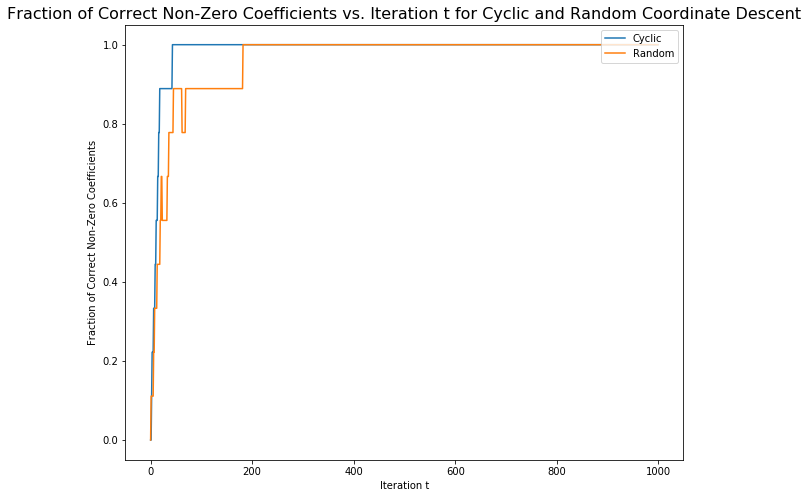

In [24]:
plt.figure(figsize=(10,8))
plt.plot(range(len(beta_cyc)), list(map(lambda b: frac_correct_nonzero(beta_sklearn_T, b), beta_cyc)))
plt.plot(range(len(beta_rand)), list(map(lambda b: frac_correct_nonzero(beta_sklearn_T, b), beta_rand)))
plt.legend(['Cyclic', 'Random'], loc='upper right')
plt.title('Fraction of Correct Non-Zero Coefficients vs. Iteration t for Cyclic and Random Coordinate Descent', 
          fontsize=16)
plt.xlabel('Iteration t')
plt.ylabel('Fraction of Correct Non-Zero Coefficients');

Here, we see the fraction of correct non-zero coefficients converges quickly - faster than the convergence for objective value. This makes sense intuitively. Additionally, cyclic coordinate descent appears to converge to 100% correct non-zero coeffcients faster than random coordinate descent. This also makes sense as cyclic is guaranteed to have updated each entry in the Beta vector (given # iterations > d) while there is a non-zero chance that random coordinate descent doesn't update a particular entry in the Beta vector.

In [25]:
def frac_correct_zero(b_sklearn, b):
    correct_zero_indices = np.where(b_sklearn == 0)[0]
    total_correct_zero_coefs = len(b_sklearn[correct_zero_indices])
    zero_coefs = len(b[np.where((b_sklearn == 0) & (b == 0))[0]])
    return zero_coefs/total_correct_zero_coefs

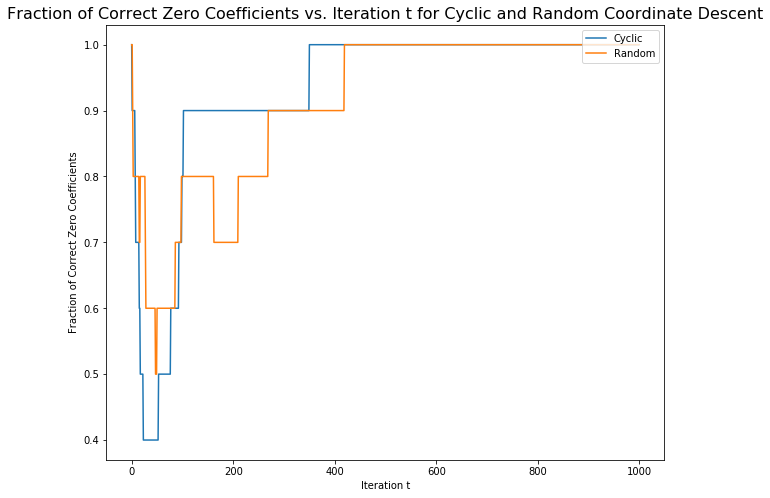

In [26]:
plt.figure(figsize=(10,8))
plt.plot(range(len(beta_cyc)), list(map(lambda b: frac_correct_zero(beta_sklearn_T, b), beta_cyc)))
plt.plot(range(len(beta_rand)), list(map(lambda b: frac_correct_zero(beta_sklearn_T, b), beta_rand)))
plt.legend(['Cyclic', 'Random'], loc='upper right')
plt.title('Fraction of Correct Zero Coefficients vs. Iteration t for Cyclic and Random Coordinate Descent', 
          fontsize=16)
plt.xlabel('Iteration t')
plt.ylabel('Fraction of Correct Zero Coefficients');

Here, we see the number of correct zero coefficients decrease first, then increase, due to the fact that the Beta vector is initialized at zero. Cyclic coordinate descent appears to also converge faster on this measure as well, which makes sense due to the aforementioned reasons.

## Exercise 2

(a) Generate a simulated data set with 30 observations in each of three classes (i.e. 90 observations total), and 60 features. Hint: There are a number of functions in numpy that you can use to generate data. One example is the numpy.random.normal() func- tion; numpy.random.uniform() is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes.

In [34]:
X_pca = np.append(
        np.random.uniform(0, 50, size=(30, 60)), np.append(
            np.random.uniform(50, 100, size=(30, 60)), 
            np.random.uniform(100, 150, size=(30, 60)),
            axis=0
        ), axis=0
    )

In [35]:
X_pca.shape

(90, 60)

In [36]:
Z = X_pca - X_pca.mean(axis=0)

(b) Run your own normalized Oja algorithm on the 90 observations. This algorithm was discussed in the week 8 lecture. Plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then you’re done. If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes.

In [37]:
def prep_cov_mat(z):
    return 1/(z.shape[0]-1)*(z.T @ z)

In [38]:
def oja(x, max_iter = 1000):
    w = np.random.rand(60)
    w = (w/np.sqrt(np.sum(w**2)))[:, np.newaxis]
    eta = 1
    m = x.T@x

    for i in range(max_iter):
        w_new = w + (eta/(i+1))*(m @ w)
        w = w_new/np.linalg.norm(w_new)
    
    return w

In [39]:
def proj_k_pc(Z, k):
    A = prep_cov_mat(Z)
    eigvec = list()
    
    for i in range(k):
        eigvec.append(oja(A, 1000))
        eigval = (eigvec[i].T@A@eigvec[i])[0][0]/(eigvec[i].T@eigvec[i])[0][0]
        A = A - eigval*(eigvec[i]@eigvec[i].T)
    
    Z_proj = Z @ np.concatenate(eigvec[0:k], axis=1)
    
    return Z_proj, eigvec

In [40]:
Z_proj_2d, Z_top2_eigvec = proj_k_pc(Z, 2)

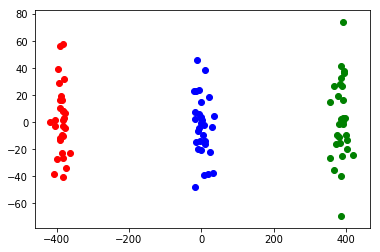

In [41]:
plt.scatter(Z_proj_2d[0:30, 0], Z_proj_2d[0:30, 1], color='red')
plt.scatter(Z_proj_2d[30:60, 0], Z_proj_2d[30:60, 1], color='blue')
plt.scatter(Z_proj_2d[60:90, 0], Z_proj_2d[60:90, 1], color='green')

### Comparing with sklearn.PCA

Compare your results to the ones obtained with scikit-learn’s PCA algorithm.

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(Z)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

First Principal Component

In [43]:
pca.components_[0].round(4)

array([0.1271, 0.128 , 0.1268, 0.138 , 0.1253, 0.1278, 0.1259, 0.12  ,
       0.1307, 0.1278, 0.1306, 0.1298, 0.1301, 0.1278, 0.1303, 0.1308,
       0.1323, 0.1283, 0.1243, 0.1326, 0.1231, 0.1346, 0.1327, 0.1272,
       0.1308, 0.1277, 0.1274, 0.1304, 0.126 , 0.132 , 0.1294, 0.1316,
       0.1287, 0.1318, 0.1297, 0.124 , 0.1317, 0.1321, 0.1298, 0.1212,
       0.1335, 0.1248, 0.1326, 0.1343, 0.1304, 0.1326, 0.1295, 0.1295,
       0.14  , 0.1279, 0.1242, 0.1247, 0.121 , 0.1405, 0.1248, 0.1282,
       0.1247, 0.1294, 0.1262, 0.1272])

In [44]:
# Error between my implementation and sklearn.PCA
(Z_top2_eigvec[0].squeeze() - pca.components_[0]).round(4)

array([-0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
        0., -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,
        0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,
        0.,  0.,  0., -0.,  0., -0., -0., -0.])

Second Principal Component

In [45]:
pca.components_[1].round(4)

array([ 0.168 , -0.1202,  0.1393, -0.0684, -0.0928, -0.0457,  0.1118,
       -0.0219, -0.1112,  0.2227, -0.1026, -0.1217,  0.0185, -0.1577,
        0.0822, -0.171 , -0.1353,  0.2452, -0.148 , -0.0529, -0.0528,
        0.1043, -0.0687, -0.0417,  0.2711, -0.0978,  0.0602,  0.108 ,
       -0.2077,  0.136 , -0.1153, -0.1572, -0.0921, -0.017 ,  0.2005,
        0.0735,  0.0896,  0.1903, -0.113 , -0.062 , -0.0969, -0.2123,
        0.094 , -0.0361,  0.1447,  0.1799,  0.0389, -0.1006,  0.0287,
       -0.1309, -0.1445,  0.108 , -0.0145, -0.118 , -0.1464,  0.2247,
       -0.0691,  0.1282,  0.0844,  0.1733])

In [46]:
# Error between my implementation and sklearn.PCA
(Z_top2_eigvec[1].squeeze() - pca.components_[1]).round(4)

array([ 0., -0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0.,
       -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0., -0., -0., -0., -0.,  0., -0., -0.,  0.,  0.,
       -0.,  0.,  0.,  0., -0., -0.,  0., -0.])

Both principal vectors appear to match exactly with our implementation of PCA using the normalized Oja algorithm.

## Exercise 3

(a) Use the numpy.random.normal() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100.

In [106]:
X_3 = np.random.normal(size=100)
noise_3 = np.random.normal(size=100)

In [107]:
# from sklearn import preprocessing

# scaler_3 = preprocessing.StandardScaler().fit(X_3[:, np.newaxis])
# X_3 = scaler_3.transform(X_3[:, np.newaxis]).squeeze()


(b) Generate a response vector Y of length n = 100 according to the model $Y = \beta_0 + \beta_1X+\beta_2X^2 +\beta_3X^3 + \epsilon$,
where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice. Here superscripts denote powers of X.

In [108]:
b_0 = 5
b_1 = 4
b_2 = 3
b_3 = 2

y_3 = b_0 + b_1*X_3 + b_2*X_3**2 + b_3*X_3**3 + noise_3

In [109]:
# scaler_3 = preprocessing.StandardScaler().fit(y_3[:, np.newaxis])
# y_3 = scaler_3.transform(y_3[:, np.newaxis]).squeeze()

In [110]:
y_3

array([  3.35162066,   2.1019753 ,   3.27948969,  13.30940046,
        15.69546054,   8.47024144,  10.92475558,   6.05465086,
        36.02666134,   2.0354291 ,  -1.01949678,   6.48507643,
         2.19586897,   3.88487271,   4.87394565,  23.93818814,
        21.62285019,   3.75851488,   4.52372782,   5.51562557,
         5.88495899,   7.15458154,   2.32735347,   5.32520907,
         5.70328542,   6.00508782,  -1.43376189,   1.12867908,
         4.6143867 ,   2.34020125,   2.79217841,   3.83064514,
         4.76146234,   4.40568926,   4.25463297,   8.73426361,
        22.4191278 ,   8.61094589,   6.61276273,   5.55689583,
         4.60641778,   6.59662261,   6.73247361,   3.43023865,
        31.14716596,   2.470699  ,   4.44573514,   8.3109547 ,
         4.10527216,  31.88399007,   3.04479969,  15.6113692 ,
        89.78777314,   0.86882769,   5.30480237,   4.78806576,
         1.71121794,  22.36680698,   4.60699535,   4.28635268,
         4.59087697,   5.63665685,   8.82147893,   2.55

(c) Now fit a lasso model to the simulated data, using $X, X^2, ... , X^{10}$ as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained.

In [111]:
X_preds_3 = np.concatenate([(X_3**i)[:, np.newaxis] for i in range(1, 11)], axis=1)

In [112]:
from sklearn.linear_model import LassoCV

lassocv_3 = LassoCV(fit_intercept=True, cv=5)
lassocv_3.fit(X_preds_3, y_3)
# opt_lamb = lassocv_3.alpha_*2 #different objective function from ours

/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/data558/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did no

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [113]:
lassocv_3.alpha_*2

444.53862779763716

In [120]:
lassocv_3.coef_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00506917, 0.00048532])

Here, we see that only the higher powers of X (9 and 10) have passsed feature selection. Lasso appears to have selected against the smaller powers of X as irrelevant. This is likely because the high powers highly outweight the smaller powers of X due to the scale. One option we have is to apply standard scaling to the features before training. We see that the coefficients for the non-zero entries (highest powers of X) are fairly small: on the order of magnitude of 10^-3 and 10^-4.

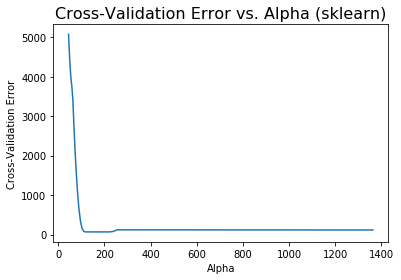

In [115]:
plt.plot(lassocv_3.alphas_[-50:], np.mean(lassocv_3.mse_path_[-50:], axis=1))
plt.title('Cross-Validation Error vs. Alpha (sklearn)', fontsize=16)
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Error');

Here we see the optimal alpha value at the lowest CV error point (not showing all alpha as it makes the graph unclear). CV error taken as mean across the 5 folds for each alpha. Note that our lambda = 2*alpha since the objective function that sklearn is optimizing is a factor of 1/2 from ours.

(d) Now generate a response vector Y according to the model $Y = \beta_0 + \beta_7X^7 + \epsilon$,
and fit a lasso model. Discuss the results obtained.

In [116]:
b_7 = 4

y_3d = b_0 + b_7*X_3**7 + noise_3

In [117]:
lassocv_3d = LassoCV(fit_intercept=True, cv=5)
lassocv_3d.fit(X_preds_3, y_3d)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [118]:
lassocv_3d.alpha_*2

5929.5556832348675

In [119]:
lassocv_3d.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.51771883, -0.00866963])

We see a similar story here: the lower power features are selected against by LASSO and only the higest power features remain (9 and 10), likely due to a similar story.